# FRInGe Demo Notebook (Fisher–Rao Integrated Gradients)

This notebook runs a single-image FRInGe attribution, logs diagnostics, and produces the **geometry plot** (Riemannian vs Euclidean per-step distance) plus optional attribution visualizations.

**Assumptions**
- You are running this notebook from the repository root (so imports like `from FisherRaoIG...` work).
- Your image exists at `../examples/n01580077_jay.JPEG` (edit the path if needed).


In [8]:
# If you're in a fresh environment, you may need:
# !pip install torch torchvision numpy matplotlib tqdm

import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

from FisherRaoIG.plot_utils import (
    set_icml_matplotlib_style,
    visualize_geometry,
    visualize_attr_triplet,
)
from FisherRaoIG.plot_intermediates import visualize_steps_prev_delta

from metrics.MetricsWrapper import MetricsWrapper
from utils import denormalize_image, load_model, load_image

# Import your class + logging config from your module.
# If the class is defined in a script instead, paste it into a cell or
# replace this import with the right module path.
from FisherRaoIG.BiharmonicFisherRaoIntegratedGradients import FisherRaoIntegratedGradients, LogConfig

## 1) Load model + image

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model, transformation = load_model("resnet18", device=device)

# Edit if needed
img_path = "./examples/n01580077_jay.JPEG"
assert os.path.exists(img_path), f"Missing image: {img_path}"

img = load_image(img_path, transformation, device=device)
batch = img  # (1,C,H,W)

with torch.no_grad():
    logits0 = model(batch)
    target_idx = logits0.argmax(dim=1)

print("Target index:", target_idx.item())


Using device: cuda
Target index: 17


## 2) Run FRInGe attribution

Tune the hyperparameters below to explore stability and geometry.

In [17]:
def model_forward_batch(x, target):
    return model(x).gather(1, target[:, None]).squeeze(1)

ig = FisherRaoIntegratedGradients(
    model=model,
    model_forward=model_forward_batch,
    target_idx=target_idx,
    use_exact_jvp=True,
)

cfg = LogConfig(
    enabled=True,
    to_cpu_numpy=True,
    store_viz=True,
    plot_viz=False,  # True = show intermediate panels during descent
    viz_every=3,
)

attributions, info = ig.attribute(
    batch,
    # core loop
    max_correction_steps=1,
    cg_max_iter=20,
    fisher=True,
    # trust region
    eta_base=10,
    delta_euc=5,
    kl_target=0.001,
    # damping / regularization
    gamma=0.01,
    alpha_start=0.001,
    alpha_end=0.001,
    diag_floor=0.01,
    clamp_max_diag=100,
    clamp_min_diag=0.001,
    gauss_blur_sigma_diag=2.0,
    gauss_blur_kernel_diag=5,
    # logging
    log_cfg=cfg,
    denormalize_image=denormalize_image,
    verbose=True,
)

print("Returned attribution shape:", tuple(attributions.shape))
print("Logged keys (sample):", list(info.keys())[:15], "...")


Fisher Descent:   1%|▏         | 1/75 [00:00<01:06,  1.11it/s]

20


Fisher Descent:   3%|▎         | 2/75 [00:01<00:58,  1.26it/s]

14


Fisher Descent:   4%|▍         | 3/75 [00:02<00:54,  1.32it/s]

15


Fisher Descent:   5%|▌         | 4/75 [00:02<00:49,  1.44it/s]

15


Fisher Descent:   7%|▋         | 5/75 [00:03<00:45,  1.52it/s]

15


Fisher Descent:   8%|▊         | 6/75 [00:04<00:43,  1.58it/s]

16


Fisher Descent:   9%|▉         | 7/75 [00:04<00:42,  1.60it/s]

17


Fisher Descent:  11%|█         | 8/75 [00:05<00:42,  1.59it/s]

18


Fisher Descent:  12%|█▏        | 9/75 [00:06<00:42,  1.55it/s]

19


Fisher Descent:  13%|█▎        | 10/75 [00:06<00:45,  1.42it/s]

20


Fisher Descent:  15%|█▍        | 11/75 [00:07<00:48,  1.33it/s]

20


Fisher Descent:  16%|█▌        | 12/75 [00:08<00:49,  1.28it/s]

20


Fisher Descent:  17%|█▋        | 13/75 [00:09<00:50,  1.23it/s]

20


Fisher Descent:  19%|█▊        | 14/75 [00:10<00:50,  1.21it/s]

20


Fisher Descent:  20%|██        | 15/75 [00:11<00:47,  1.25it/s]

20


Fisher Descent:  21%|██▏       | 16/75 [00:11<00:46,  1.26it/s]

20
20


Fisher Descent:  24%|██▍       | 18/75 [00:14<00:54,  1.06it/s]

20


Fisher Descent:  25%|██▌       | 19/75 [00:14<00:49,  1.13it/s]

20
20


Fisher Descent:  28%|██▊       | 21/75 [00:16<00:53,  1.02it/s]

20


Fisher Descent:  29%|██▉       | 22/75 [00:17<00:48,  1.09it/s]

20


Fisher Descent:  31%|███       | 23/75 [00:18<00:45,  1.15it/s]

20
20


Fisher Descent:  32%|███▏      | 24/75 [00:19<00:47,  1.08it/s]

20


Fisher Descent:  35%|███▍      | 26/75 [00:21<00:49,  1.01s/it]

20


Fisher Descent:  36%|███▌      | 27/75 [00:22<00:44,  1.08it/s]

20


Fisher Descent:  37%|███▋      | 28/75 [00:23<00:42,  1.11it/s]

20


Fisher Descent:  39%|███▊      | 29/75 [00:24<00:42,  1.09it/s]

20
20


Fisher Descent:  41%|████▏     | 31/75 [00:26<00:41,  1.07it/s]

20


Fisher Descent:  43%|████▎     | 32/75 [00:27<00:39,  1.09it/s]

20


Fisher Descent:  44%|████▍     | 33/75 [00:27<00:36,  1.15it/s]

20


Fisher Descent:  45%|████▌     | 34/75 [00:28<00:33,  1.22it/s]

20


Fisher Descent:  47%|████▋     | 35/75 [00:29<00:31,  1.26it/s]

20


Fisher Descent:  48%|████▊     | 36/75 [00:29<00:29,  1.31it/s]

20


Fisher Descent:  49%|████▉     | 37/75 [00:30<00:28,  1.33it/s]

20


Fisher Descent:  51%|█████     | 38/75 [00:31<00:27,  1.35it/s]

20


Fisher Descent:  52%|█████▏    | 39/75 [00:32<00:27,  1.30it/s]

20


Fisher Descent:  53%|█████▎    | 40/75 [00:33<00:28,  1.22it/s]

20


Fisher Descent:  55%|█████▍    | 41/75 [00:34<00:28,  1.19it/s]

20


Fisher Descent:  56%|█████▌    | 42/75 [00:34<00:27,  1.19it/s]

20


Fisher Descent:  57%|█████▋    | 43/75 [00:35<00:26,  1.19it/s]

20


Fisher Descent:  59%|█████▊    | 44/75 [00:36<00:26,  1.18it/s]

20


Fisher Descent:  60%|██████    | 45/75 [00:37<00:25,  1.19it/s]

20


Fisher Descent:  61%|██████▏   | 46/75 [00:38<00:24,  1.18it/s]

20


Fisher Descent:  63%|██████▎   | 47/75 [00:39<00:24,  1.17it/s]

20


Fisher Descent:  64%|██████▍   | 48/75 [00:40<00:23,  1.13it/s]

20


Fisher Descent:  65%|██████▌   | 49/75 [00:40<00:21,  1.20it/s]

20


Fisher Descent:  67%|██████▋   | 50/75 [00:41<00:19,  1.26it/s]

20


Fisher Descent:  68%|██████▊   | 51/75 [00:42<00:18,  1.30it/s]

20


Fisher Descent:  69%|██████▉   | 52/75 [00:42<00:17,  1.34it/s]

20


Fisher Descent:  71%|███████   | 53/75 [00:43<00:16,  1.37it/s]

20


Fisher Descent:  72%|███████▏  | 54/75 [00:44<00:15,  1.38it/s]

20


Fisher Descent:  73%|███████▎  | 55/75 [00:45<00:14,  1.34it/s]

20


Fisher Descent:  75%|███████▍  | 56/75 [00:46<00:14,  1.29it/s]

20


Fisher Descent:  76%|███████▌  | 57/75 [00:46<00:14,  1.22it/s]

20


Fisher Descent:  77%|███████▋  | 58/75 [00:47<00:14,  1.20it/s]

20


Fisher Descent:  79%|███████▊  | 59/75 [00:48<00:13,  1.20it/s]

20


Fisher Descent:  80%|████████  | 60/75 [00:49<00:12,  1.20it/s]

20


Fisher Descent:  81%|████████▏ | 61/75 [00:50<00:11,  1.20it/s]

20


Fisher Descent:  83%|████████▎ | 62/75 [00:51<00:10,  1.18it/s]

20


Fisher Descent:  84%|████████▍ | 63/75 [00:52<00:10,  1.17it/s]

20


Fisher Descent:  85%|████████▌ | 64/75 [00:52<00:09,  1.15it/s]

20


Fisher Descent:  87%|████████▋ | 65/75 [00:53<00:08,  1.19it/s]

20


Fisher Descent:  88%|████████▊ | 66/75 [00:54<00:07,  1.24it/s]

20


Fisher Descent:  89%|████████▉ | 67/75 [00:55<00:06,  1.27it/s]

20


Fisher Descent:  91%|█████████ | 68/75 [00:55<00:05,  1.31it/s]

20


Fisher Descent:  92%|█████████▏| 69/75 [00:56<00:04,  1.34it/s]

20


Fisher Descent:  93%|█████████▎| 70/75 [00:57<00:03,  1.36it/s]

20


Fisher Descent:  95%|█████████▍| 71/75 [00:58<00:03,  1.30it/s]

20


Fisher Descent:  96%|█████████▌| 72/75 [00:59<00:02,  1.25it/s]

20


Fisher Descent:  97%|█████████▋| 73/75 [00:59<00:01,  1.22it/s]

20


Fisher Descent:  99%|█████████▊| 74/75 [01:00<00:00,  1.21it/s]

20


Fisher Descent: 100%|██████████| 75/75 [01:01<00:00,  1.22it/s]

20
Returned attribution shape: (1, 3, 224, 224)
Logged keys (sample): ['relative_residual', 'alpha_t', 'damped_fisher_step_size', 'n_cg_steps', 'fraction_D_vs_G', 'pure_fisher_step_size', 'euclidean_norm_sq', 'diag_min', 'diag_med', 'diag_max', 'D_min', 'D_med', 'D_max', 'D_cond_proxy', 'total_grad_norm'] ...


## 3) Geometry plot (Riemannian vs Euclidean per-step distance)

This is the key diagnostic to understand how your **Euclidean trust region** interacts with the **Fisher pullback geometry**.

/home/gabriele-martino/Desktop/FRInGe/FisherRaoIG/plot_utils.py:745: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


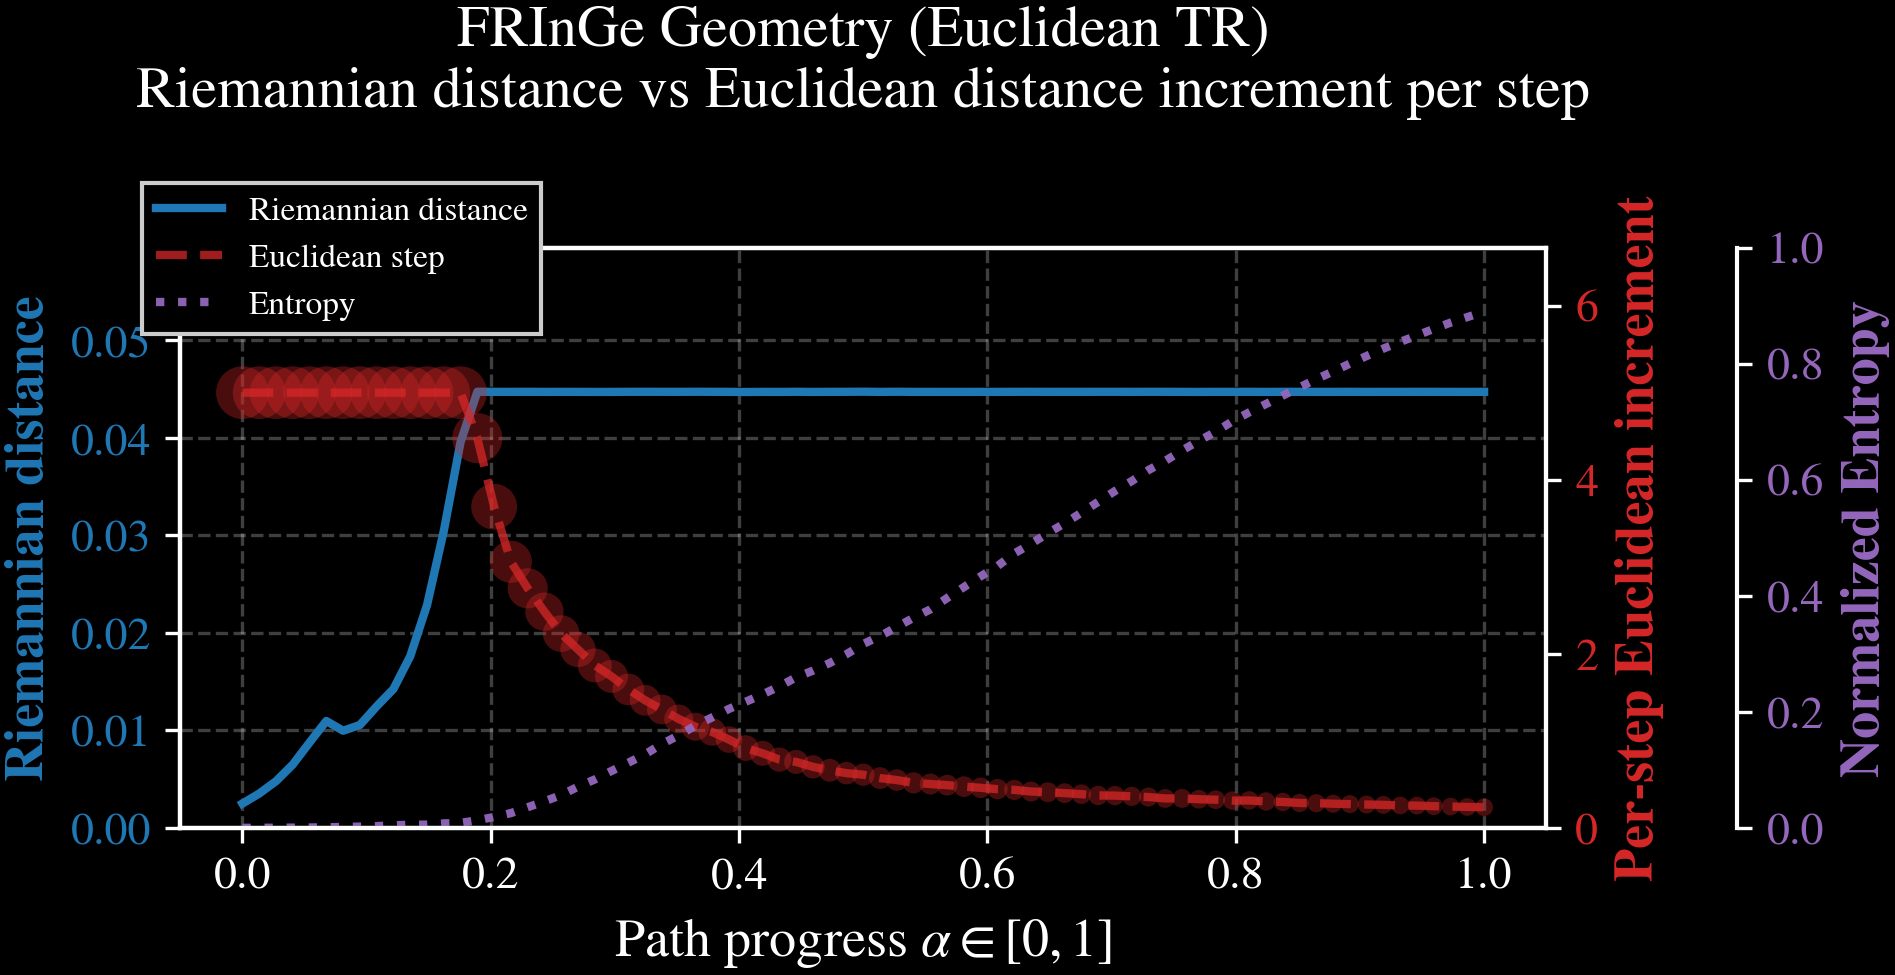

In [18]:
delta_euclidean = np.asarray(info["delta_euclidean"]).squeeze()
delta_riemann = np.asarray(info["delta_riemann"]).squeeze()
entropy = np.asarray(info["entropy"]).squeeze()

num_classes = logits0.shape[-1]
entropy = entropy / np.log(num_classes)

T = len(delta_euclidean)
steps = np.arange(T, dtype=float) / max(T, 1)

set_icml_matplotlib_style(
    base_fontsize=13,
    tick_fontsize=11,
    legend_fontsize=8,
    title_fontsize=14,
    line_width=2.0,
)

visualize_geometry(
    delta_riemann,
    delta_euclidean,
    steps,
    entropy=entropy,
    title="FRInGe Geometry (Euclidean TR)\nRiemannian distance vs Euclidean distance increment per step",
)


## 4) Optional: attribution visualization

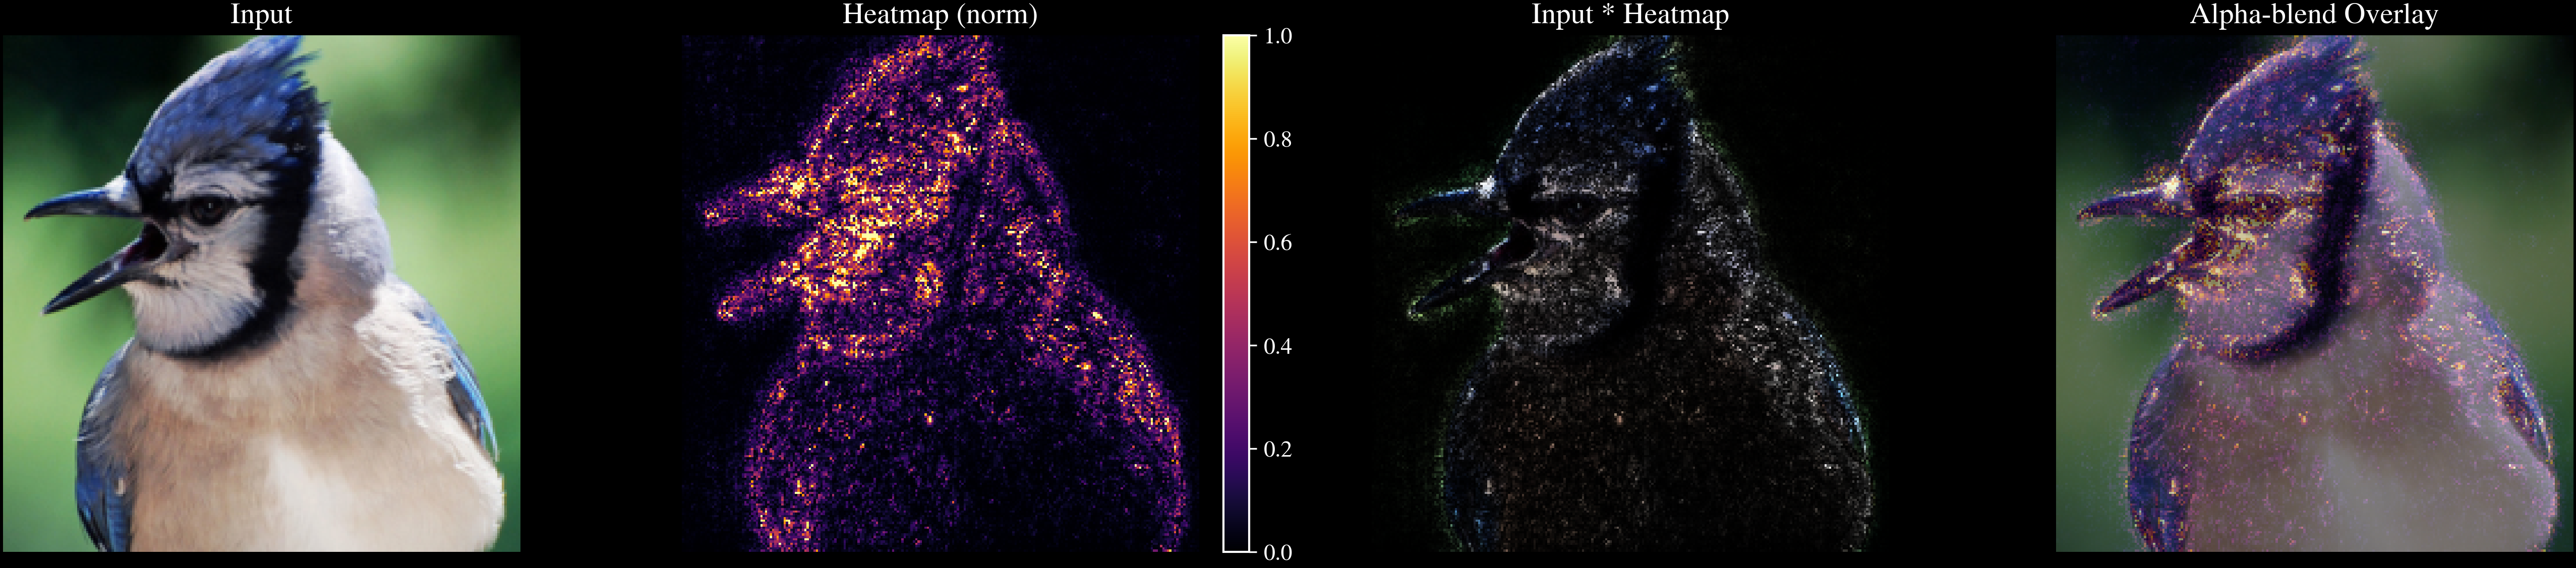

In [11]:
visualize_attr_triplet(denormalize_image(batch), attributions)


## 5) Optional: intermediate steps panel

Requires `store_viz=True` in `LogConfig`.

[0, 2, 5, 8, 24]
cols 5
NUM COLS 5


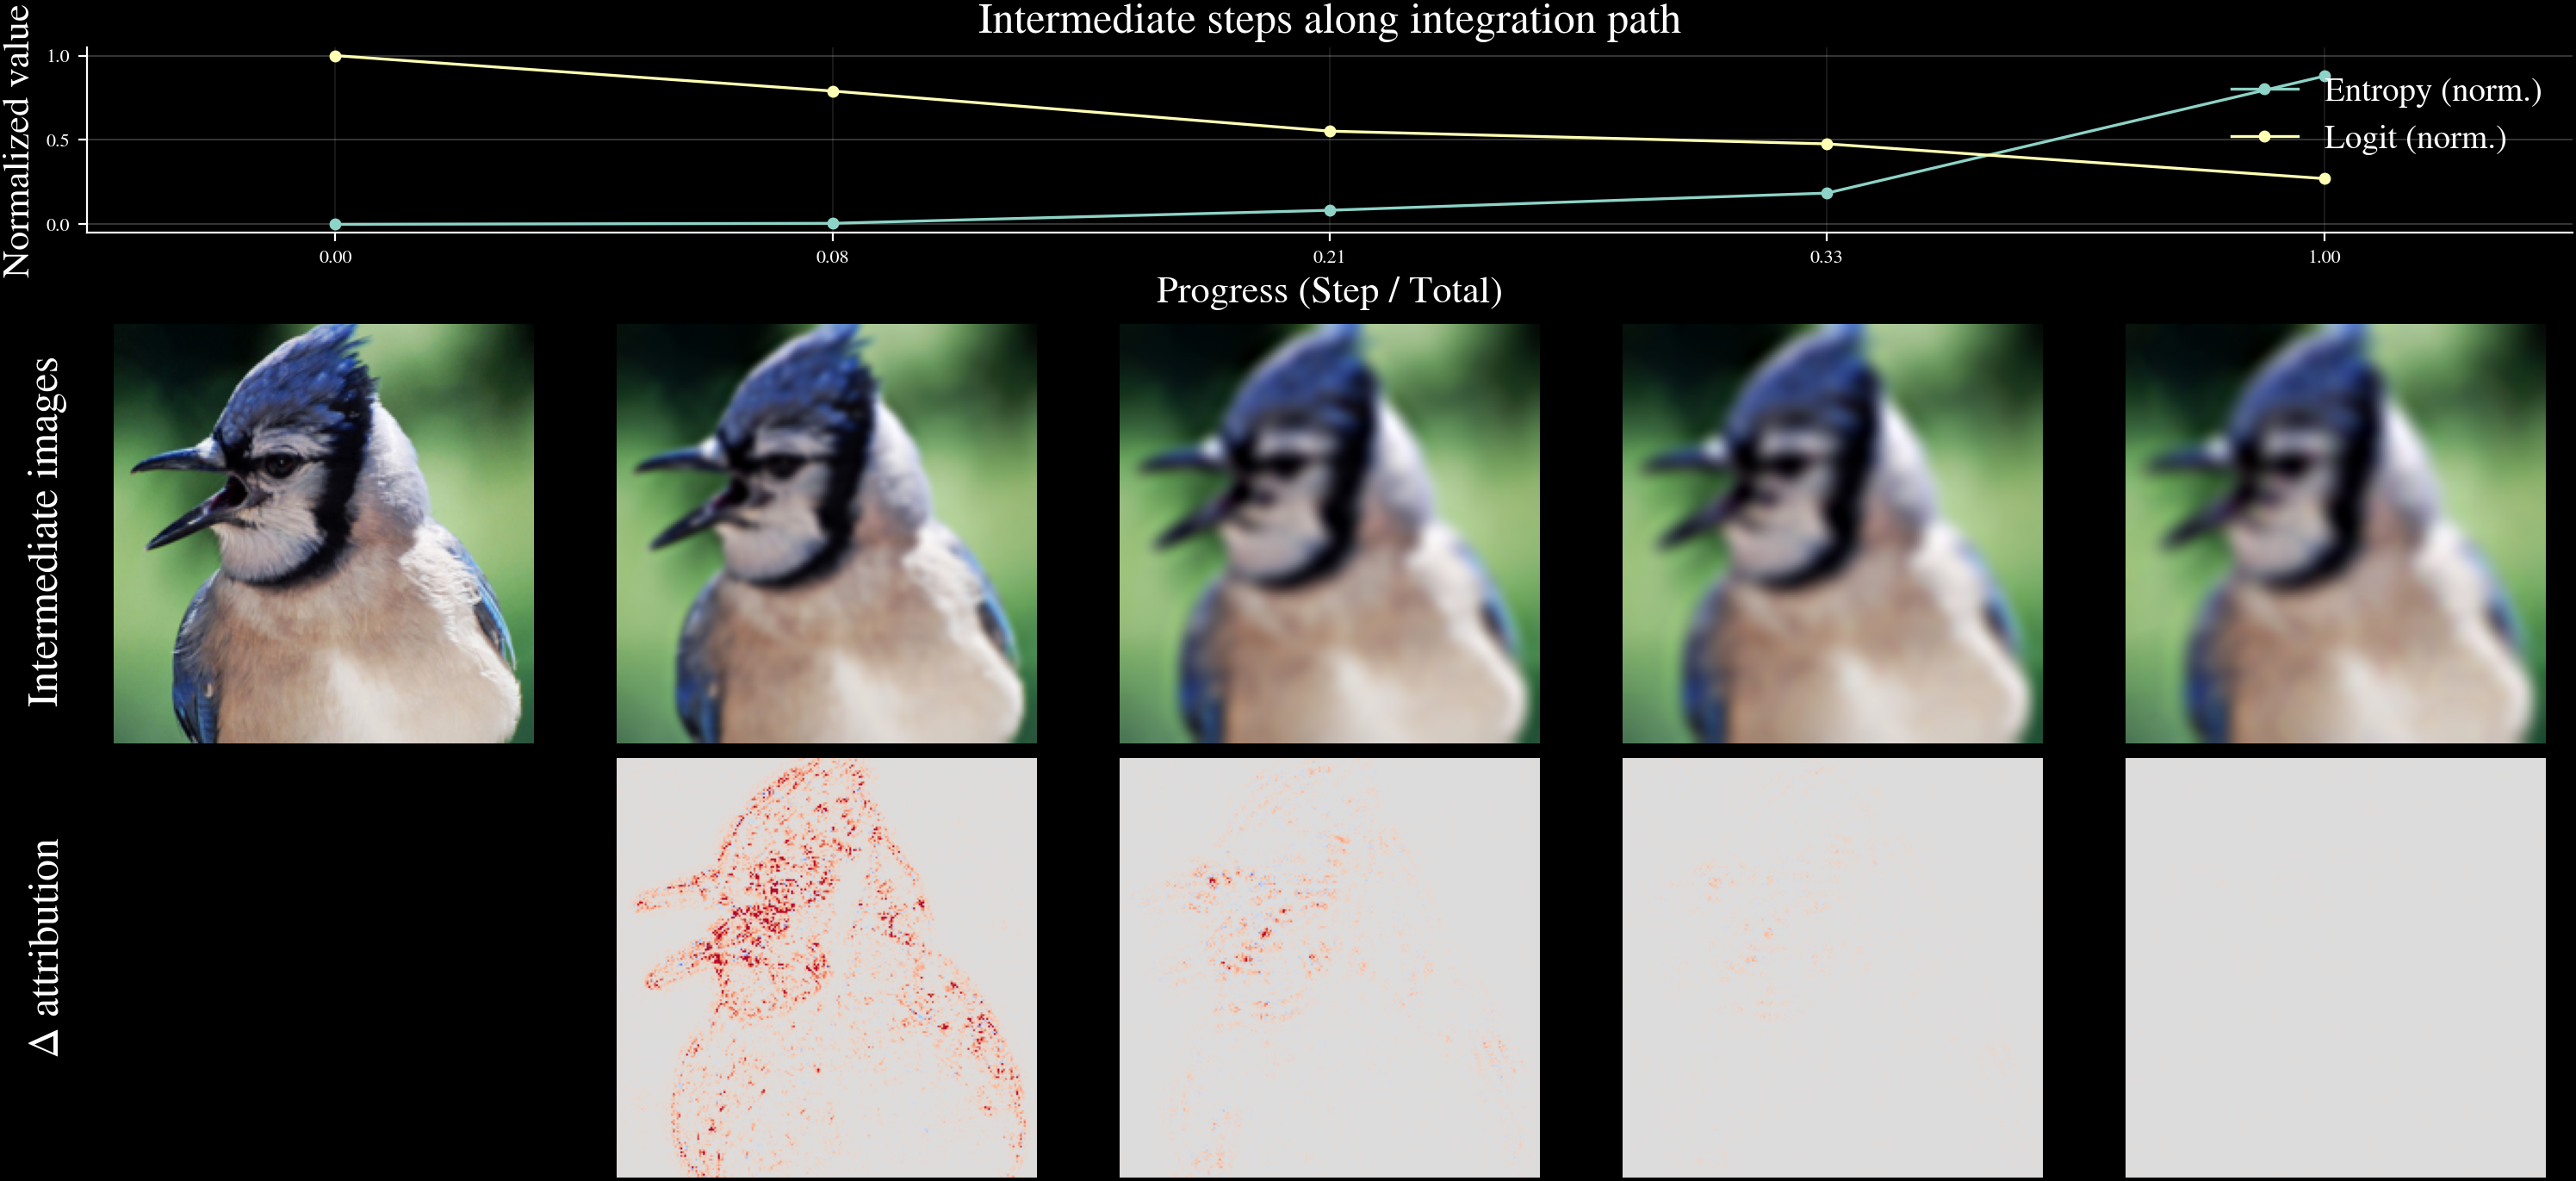

In [12]:
if "intermediate_x" in info and len(info["intermediate_x"]) > 0:
    T = len(info["intermediate_x"])
    idxs = [0, int(0.1*T), int(0.2*T), int(0.35*T), T-1]
    idxs = sorted(set(max(0, min(T-1, i)) for i in idxs))
    visualize_steps_prev_delta(info, steps=idxs, C=num_classes)
else:
    print("No intermediate viz stored. Set LogConfig(store_viz=True).")


## 6) Optional: save logs


In [ ]:
save_path = "fisher_rao_info_with_euclidean_TR.pkl"
with open(save_path, "wb") as f:
    pickle.dump(info, f)
print("Saved:", save_path)


## 7) Optional: run metrics

Requires your `MetricsWrapper` and metric implementations to be available.

In [19]:
run_metrics = True
if run_metrics:
    metrics = MetricsWrapper(ig, model)
    scores = metrics.extract_insertion_deletion_auc(batch, attributions)
    print(f"Insertion AUC: {scores['insertion_auc']:.4f}")
    print(f"Deletion AUC:  {scores['deletion_auc']:.4f}")

    mas_scores = metrics.extract_mas_score(batch, attributions)
    print(f"MAS Ins AUC:   {mas_scores['insertion']:.4f}")
    print(f"MAS Del AUC:   {mas_scores['deletion']:.4f}")

    infidelity_score = metrics.extract_infidelity_score(
        batch,
        attributions,
        target_idx=target_idx,
        n_perturbations=50,
        noise_scale=0.02,
    )
    print(infidelity_score.squeeze().item())
else:
    print("Metrics skipped. Set run_metrics=True to enable.")


Computing insertion deletion AUC
Insertion AUC: 0.8652
Deletion AUC:  0.1543
Computing mas score
MAS Ins AUC:   0.8298
MAS Del AUC:   0.8474
Running Infidelity Check (N=50)...


Perturbations: 100%|██████████| 50/50 [00:00<00:00, 332.76it/s]

0.0426744744181633
